In [1]:
import numpy as np
import cv2
import os
import dlib
import json

## Display the video

In [5]:
video_path = 'classroom.mp4'

cap = cv2.VideoCapture(video_path)

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break
    
    cv2.imshow('Face Detection', frame)
    
    # Add delay of 100ms instead of 1ms
    key = cv2.waitKey(30)
    if key == ord('q'):  # Quit when 'q' is pressed
        print("Exit key pressed")
        break

cap.release()
cv2.destroyAllWindows()

Exit key pressed


## Extract the frames from the video

In [11]:
def extract_frame(video_path, frame_numbers=[100]):
    os.makedirs('frames', exist_ok=True)
    # Open the video file
    cap = cv2.VideoCapture(video_path)
    
    # Check if the video was successfully opened
    if not cap.isOpened():
        print(f"Error: Cannot open video file {video_path}")
        return
    for frame_number in frame_numbers:
        # Set the video position to the random frame
        cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number)
        
        # Read the frame from the video
        ret, frame = cap.read()
        if ret:
            # Save the frame as an image file
            cv2.imwrite(f'frames/frame_{frame_number}.jpg', frame)
        else:
            print("Error: Could not read the frame from the video")
        
    # Release the video capture object
    cap.release()

# Usage
video_path = 'classroom.mp4'  # Replace with your video file path
extract_frame(video_path, [100,200,300,400,500])

## Detect the face in the frames and create a bounding box around the face and save the frames also crop the face and save it + extract the embeddings of the face (with augmentation)

Low-quality embedding for frame 200, face 2
Low-quality embedding for frame 200, face 2
Low-quality embedding for frame 200, face 2
Low-quality embedding for frame 500, face 3
Low-quality embedding for frame 500, face 3
Face detection, data augmentation, and embedding extraction completed for the frames


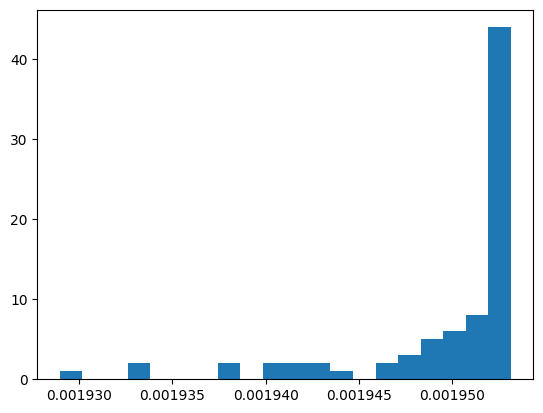

In [199]:
import os
import cv2
import numpy as np
import torch  #*** Added for FaceNet model ***
from facenet_pytorch import InceptionResnetV1  #*** Added for FaceNet model ***
import dlib  # Make sure dlib is imported

#*** Load the FaceNet model instead of Dlib face recognition model ***
facenet_model = InceptionResnetV1(pretrained='vggface2').eval()

# Load the Dlib CNN face detector and shape predictor
cnn_face_detector = dlib.cnn_face_detection_model_v1('./models/mmod_human_face_detector.dat')
shape_predictor = dlib.shape_predictor('./models/shape_predictor_68_face_landmarks.dat')

if os.path.exists('./frames/face_boxes'):
    shutil.rmtree('./frames/face_boxes')
if os.path.exists('./frames/face_crops'):
    shutil.rmtree('./frames/face_crops')
if os.path.exists('./frames/embeddings'):
    shutil.rmtree('./frames/embeddings')
    
# Create directories to store output images and embeddings
os.makedirs('./frames/face_boxes', exist_ok=True)
os.makedirs('./frames/face_crops', exist_ok=True)
os.makedirs('./frames/embeddings', exist_ok=True)


def augment_image(image):
    """
    Applies random augmentations to the image.
    Augmentations: Rotation, Brightness, Gaussian Blur, Horizontal Flip.
    """
    # Random rotation
    angle = np.random.uniform(-10, 10)
    M = cv2.getRotationMatrix2D((image.shape[1]//2, image.shape[0]//2), angle, 1)
    rotated_image = cv2.warpAffine(image, M, (image.shape[1], image.shape[0]))

    # Random brightness adjustment
    brightness_factor = np.random.uniform(0.9, 1.1)
    bright_image = np.clip(rotated_image * brightness_factor, 0, 255).astype(np.uint8)

    # Gaussian blur
    if np.random.rand() > 0.5:  # Randomly apply blur 50% of the time
        blurred_image = cv2.GaussianBlur(bright_image, (3, 3), 0)
    else:
        blurred_image = bright_image

    # Random horizontal flip
    if np.random.rand() > 0.5:  # Randomly flip 50% of the time
        flipped_image = cv2.flip(blurred_image, 1)
    else:
        flipped_image = blurred_image

    return flipped_image

variance_of_embedding = []
for frame_number in [100, 200, 300, 400, 500]:
    # Load the image
    image_path = os.path.join('./frames', f'frame_{frame_number}.jpg')
    image = cv2.imread(image_path)
    
    if image is None:
        print(f"Error: Could not load image from {image_path}")
        continue

    # Convert the image to grayscale (dlib works better with grayscale)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Detect faces using the CNN detector
    faces = cnn_face_detector(gray, 1)  # The second argument is the upsampling factor

    # Loop through detected faces
    for i, face in enumerate(faces):
        x1, y1, x2, y2 = face.rect.left(), face.rect.top(), face.rect.right(), face.rect.bottom()
        margin = 20  # Add margin to avoid cutting the face
        x1 = max(0, x1 - margin)
        y1 = max(0, y1 - margin)
        x2 = min(image.shape[1], x2 + margin)
        y2 = min(image.shape[0], y2 + margin)

        # Extract the face region from the image
        face_crop = image[max(0, y1):max(0, y2), max(0, x1):max(0, x2)]

        # Apply data augmentation to the face
        augmented_faces = [face_crop]  # Original face
        for _ in range(3):  # Create 3 augmented versions of the face
            augmented_faces.append(augment_image(face_crop))

        for j, face in enumerate(augmented_faces):
            # Convert the face crop to a tensor and preprocess it for FaceNet
            face_crop_resized = cv2.resize(face, (160, 160))  # FaceNet requires 160x160 input
            face_crop_tensor = torch.tensor(face_crop_resized).permute(2, 0, 1).float().div(255).unsqueeze(0)  # Normalize to [0,1]
            
            # Check if CUDA is available and move the tensor and model to GPU if available
            if torch.cuda.is_available():
                facenet_model = facenet_model.cuda()
                face_crop_tensor = face_crop_tensor.cuda()
            
            # Get face embedding using FaceNet
            with torch.no_grad():  # No gradient computation required
                face_embedding = facenet_model(face_crop_tensor).cpu().numpy().flatten()
            variance_of_embedding.append(np.var(face_embedding))
            if np.var(face_embedding) < 0.00194:  # Threshold to tune
                print(f"Low-quality embedding for frame {frame_number}, face {i+1}")
                continue
            # Save the embedding
            embedding_filename = f'frame_{frame_number}_face_{i+1}_aug_{j}.npy'
            embedding_path = os.path.join('./frames/embeddings', embedding_filename)
            np.save(embedding_path, face_embedding)
            
            # Save the extracted face as an individual image
            face_filename = f'frame_{frame_number}_face_{i+1}_aug_{j}.jpg'
            face_crop_path = os.path.join('./frames/face_crops', face_filename)
            cv2.imwrite(face_crop_path, face)

        # Draw a rectangle around the face
        cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)
        # cv2.putText(image, f'Face {i+1}', (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

    # Save the image with the bounding boxes
    output_path = os.path.join('./frames/face_boxes', f'frame_{frame_number}_face_boxes.jpg')
    cv2.imwrite(output_path, image)

print("Face detection, data augmentation, and embedding extraction completed for the frames")
_ = plt.hist(variance_of_embedding, bins=20)

## K-Distance Plot

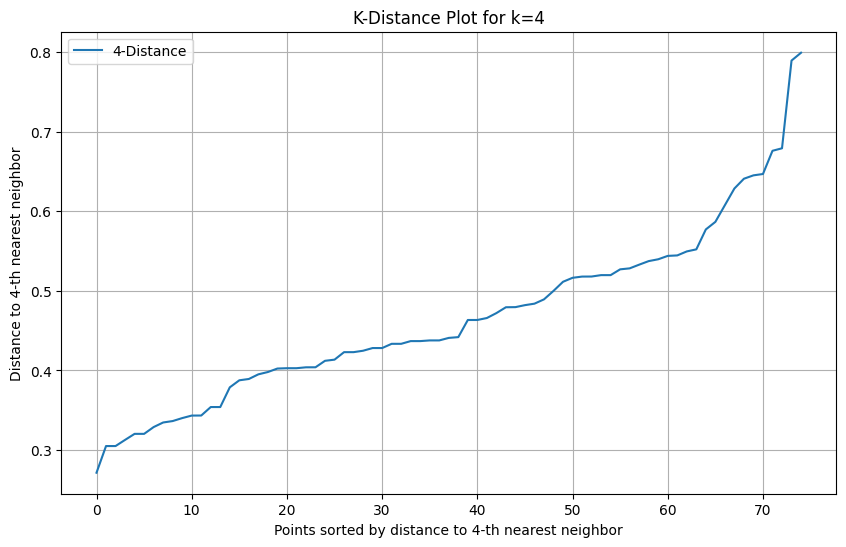

In [200]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
import os
from sklearn.cluster import DBSCAN
import shutil


# Load all embeddings
embeddings_path = './frames/embeddings'
embeddings = []
filenames = []

for file in os.listdir(embeddings_path):
    if file.endswith('.npy'):
        filepath = os.path.join(embeddings_path, file)
        embedding = np.load(filepath)
        embeddings.append(embedding)
        filenames.append(file)

embeddings = np.array(embeddings)

def plot_k_distance(X, k=4):
    """
    Plots the K-distance graph to help choose the min_samples value for DBSCAN.
    
    Parameters:
    - X: The dataset (numpy array or dataframe)
    - k: The k-th nearest neighbor distance to consider for the plot
    """
    # Step 1: Fit Nearest Neighbors to the data
    nearest_neighbors = NearestNeighbors(n_neighbors=k)
    nearest_neighbors.fit(X)
    
    # Step 2: Compute distances to the k-th nearest neighbor
    distances, indices = nearest_neighbors.kneighbors(X)
    k_distances = distances[:, k-1]  # Get the distance to the k-th nearest neighbor
    
    # Step 3: Sort the distances
    k_distances = np.sort(k_distances)
    
    # Step 4: Plot the k-distances
    plt.figure(figsize=(10, 6))
    plt.plot(k_distances, label=f'{k}-Distance')
    plt.xlabel('Points sorted by distance to {}-th nearest neighbor'.format(k))
    plt.ylabel('Distance to {}-th nearest neighbor'.format(k))
    plt.title(f'K-Distance Plot for k={k}')
    plt.grid(True)
    plt.legend()
    plt.show()

# Call the function to create the K-Distance plot
plot_k_distance(embeddings, k=4)

## Elbow Plot to Determine Optimal K

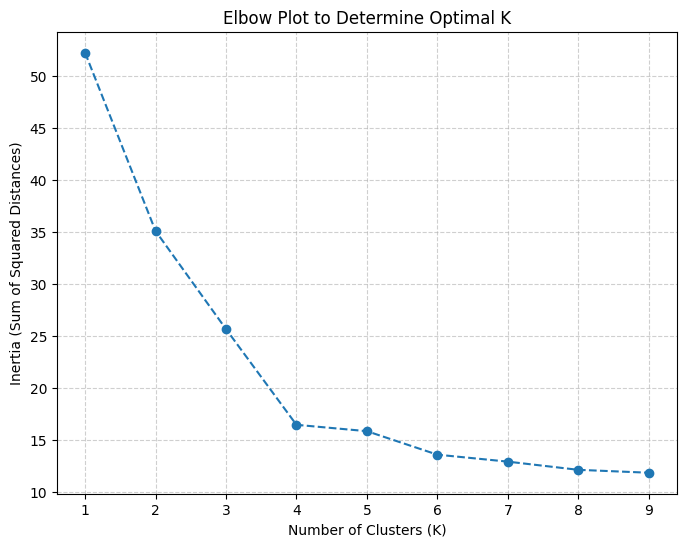

In [201]:
inertias = []
K_range = range(1, 10)  # Test K from 1 to 10

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(embeddings)
    inertias.append(kmeans.inertia_)

# Step 3: Plot the elbow plot
plt.figure(figsize=(8, 6))
plt.plot(K_range, inertias, marker='o', linestyle='--')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia (Sum of Squared Distances)')
plt.title('Elbow Plot to Determine Optimal K')
plt.xticks(K_range)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

## Cluster the Faces (For Each Student)

In [247]:
import json
if os.path.exists('./frames/clusters'):
    shutil.rmtree('./frames/clusters')
    
# Cluster the embeddings using DBSCAN
dbscan = DBSCAN(eps=0.55, min_samples=5, metric='euclidean')
labels = dbscan.fit_predict(embeddings)

# Create folders for each cluster and move images
cluster_path = './frames/clusters'
os.makedirs(cluster_path, exist_ok=True)
cluster_mapping = {}
for label, filename in zip(labels, filenames):
    if label == -1:
        continue  # -1 means outlier
    cluster_folder = os.path.join(cluster_path, f'student_{label}')
    os.makedirs(cluster_folder, exist_ok=True)
    image_file = filename.replace('.npy', '.jpg').replace('embeddings', 'face_crops')
    image_path = os.path.join('./frames/face_crops', image_file)
    if os.path.exists(image_path):
        shutil.copy(image_path, cluster_folder)
    
    cluster_mapping[filename] = label
    
with open('./frames/cluster_mapping.json', 'w') as f:
    json.dump(cluster_mapping, f, indent=4,default=str)
    
print(f"Clustering complete. Clusters saved in {cluster_path}")

Clustering complete. Clusters saved in ./frames/clusters


## PCA for Visualization

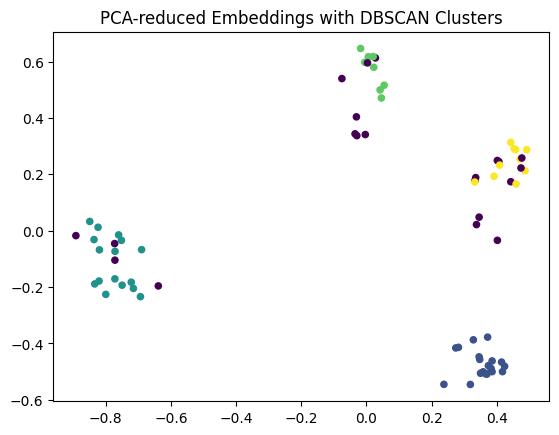

In [208]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(embeddings)

plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=labels, cmap='viridis', s=20)
plt.title('PCA-reduced Embeddings with DBSCAN Clusters')
plt.show()

# ## 3D Visualization
# from mpl_toolkits.mplot3d import Axes3D

# # Assume 'embeddings' is the high-dimensional data
# pca = PCA(n_components=3)
# reduced_embeddings = pca.fit_transform(embeddings)  # Reduce to 3 dimensions

# # 3D Scatter plot
# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')
# ax.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], reduced_embeddings[:, 2], c=labels, cmap='viridis', s=20)
# ax.set_title('3D PCA-Reduced Embeddings')
# plt.show()

## t-SNE Plot

/Users/bm/.virtualenvs/AF/lib/python3.11/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


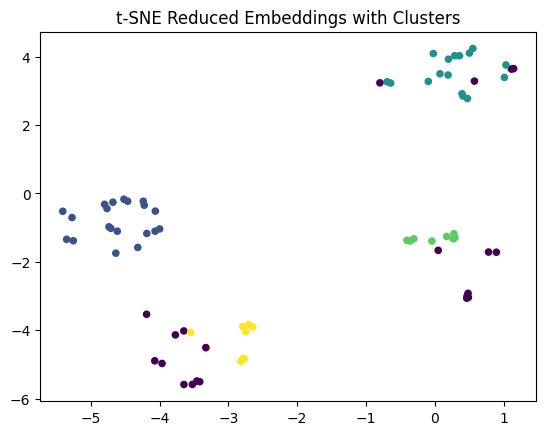

In [209]:
from sklearn.manifold import TSNE  # Import t-SNE
import matplotlib.pyplot as plt

# Assume 'embeddings' and 'labels' are defined
tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=42)
reduced_embeddings = tsne.fit_transform(embeddings)  # Reduce embeddings to 2D

# Scatter plot of t-SNE reduced embeddings
plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=labels, cmap='viridis', s=20)
plt.title('t-SNE Reduced Embeddings with Clusters')
plt.show()

## Create Mapping of Cluster to Student Names

In [212]:
import json

# Manually created mapping (could be done automatically via a labeling script)
cluster_to_student = {
    0: "S1",
    1: "S2",
    2: "S3",
    3: "S4",
}

# Save to JSON file for future use
with open("./map/cluster_to_student.json", "w") as f:
    json.dump(cluster_to_student, f)

In [219]:
import os
import json
import numpy as np

# Load the student-to-cluster mapping
with open('./map/cluster_to_student.json', 'r') as f:
    cluster_to_student = json.load(f)

# Load all existing cluster embeddings
existing_embeddings = []
existing_labels = []

embeddings_folder = './frames/embeddings'  # Path where the embeddings are saved
for filename in os.listdir(embeddings_folder):
    if filename.endswith('.npy'):
        embedding = np.load(os.path.join(embeddings_folder, filename))
        cluster_id = int(filename.split('_')[1])  # Assuming the file name contains the cluster id
        existing_embeddings.append(embedding)
        existing_labels.append(cluster_id)

existing_embeddings = np.array(existing_embeddings)

In [ ]:
from sklearn.neighbors import NearestNeighbors


def load_cluster_to_student_map(map_path="./map/cluster_to_student.json"):
    """Load the cluster-to-student mapping from a JSON file."""
    with open(map_path, "r") as f:
        cluster_to_student = json.load(f)
    return cluster_to_student


def extract_faces_from_image(image_path, face_output_folder="new_session"):
    face_paths=[]
    if os.path.exists(face_output_folder):
        shutil.rmtree(face_output_folder)
    
    cnn_face_detector = dlib.cnn_face_detection_model_v1('./models/mmod_human_face_detector.dat')
    image = cv2.imread(image_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    detected_faces = cnn_face_detector(gray, 1)
    
    for i, face in enumerate(detected_faces):
        x1, y1, x2, y2 = face.rect.left(), face.rect.top(), face.rect.right(), face.rect.bottom()
        margin = 20  # Add margin to avoid cutting the face
        x1 = max(0, x1 - margin)
        y1 = max(0, y1 - margin)
        x2 = min(image.shape[1], x2 + margin)
        y2 = min(image.shape[0], y2 + margin)

        # # Extract the face region from the image
        face_crop = image[max(0, y1):max(0, y2), max(0, x1):max(0, x2)]
        os.makedirs(face_output_folder, exist_ok=True)
        face_path = os.path.join(face_output_folder, f"face_{i}.jpg")
        cv2.imwrite(face_path, face_crop)
        face_paths.append(face_path)
        cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)
    cv2.imwrite(os.path.join(face_output_folder,"face_detected.png"),image)
    return face_paths


def extract_embeddings_from_faces(face_paths):
    """Extract embeddings for each face image."""
    embeddings = []
    for face_path in face_paths:
        try:
            face_crop = cv2.imread(face_path)
            face_crop_resized = cv2.resize(face_crop, (160, 160))  #*** FaceNet requires 160x160 input ***
            face_crop_tensor = torch.tensor(face_crop_resized).permute(2, 0, 1).float().div(255).unsqueeze(0)  #*** Normalize to [0,1] ***
            with torch.no_grad():  # No gradient computation required
                embedding = facenet_model(face_crop_tensor).cpu().numpy().flatten()
            embeddings.append(embedding)
        except Exception as e:
            print(f"Error extracting embedding for {face_path}: {e}")
    return np.array(embeddings)


def load_existing_embeddings_and_labels(embeddings_folder="./frames/embeddings", cluster_mapping_path="./frames/cluster_mapping.json"):
    """Load the previously saved embeddings and cluster labels."""
    embeddings = []
    labels = []
    filenames = []
    with open(cluster_mapping_path, 'r') as f:
        cluster_mapping = json.load(f)
        
    for filename, cluster_label in cluster_mapping.items():
        embedding_path = os.path.join(embeddings_folder, filename)
        if os.path.exists(embedding_path):
            embedding = np.load(embedding_path)
            embeddings.append(embedding)
            labels.append(cluster_label)
            filenames.append(filename)
            
    embeddings = np.array(embeddings)
    labels = np.array(labels)
    
    return embeddings, labels, filenames


def match_faces_to_clusters(new_embeddings, existing_embeddings, cluster_labels, cluster_to_student):
    """Match new embeddings to the existing clusters using KNN."""
    knn = NearestNeighbors(n_neighbors=4, metric='euclidean')
    knn.fit(existing_embeddings)
    
    student_names = []
    for i, new_embedding in enumerate(new_embeddings):
        distances, indices = knn.kneighbors(new_embedding.reshape(1, -1))
        closest_index = indices[0][0]  # Get the closest embedding
        cluster_id = cluster_labels[closest_index]  # Get the cluster ID of the closest embedding
        student_name = cluster_to_student.get(str(cluster_id), "Unknown")  # Get the student name from the cluster ID
        student_names.append(student_name)
    
    return student_names


def mark_attendance(present_students):
    """Print and mark students as present."""
    present_students_set = set(present_students)
    print(f"Students present: {present_students_set}")
    return list(present_students_set)



# 1. Load the cluster-to-student mapping
cluster_to_student = load_cluster_to_student_map(map_path="./map/cluster_to_student.json")

# 2. Extract faces from the new picture
new_image_path = "11.png"
face_paths = extract_faces_from_image(new_image_path, face_output_folder="new_session")

# 3. Extract embeddings for the new faces
new_embeddings = extract_embeddings_from_faces(face_paths)

# 4. Load existing embeddings and cluster labels
existing_embeddings, cluster_labels, filenames = load_existing_embeddings_and_labels(
embeddings_folder="./frames/embeddings", 
cluster_mapping_path="./frames/cluster_mapping.json")

# 5. Match the new embeddings with the existing cluster embeddings
present_students = match_faces_to_clusters(new_embeddings, existing_embeddings, cluster_labels, cluster_to_student)

# 6. Mark the attendance of students
mark_attendance(present_students)

Students present: {'S2', 'S3', 'S4'}


['S2', 'S3', 'S4']